# Open Data Cube - hits its stride

## CHS considering offering a CHS Open Data Cube Service

### Open Data Cube now works with STAC and COG 

- this integration is new and will get better
- Tony to present some notebooks in Teigen's Cloud Workshop Series

|                     AMAZON                     |              Google             |                       Microsoft                       |
|:----------------------------------------------:|:-------------------------------:|:-----------------------------------------------------:|
|                       AWS                      |  Google Cloud Services Platform |                         Azure                         |
|                      Linux                     |              Linux              |                         Linux                         |
|                S3 Object Storage               |      Google Object Storage      |                   Azure Blob Storage                  |
| Pangeo, ODC                                    | Google Earth Engine or Pangeo   | Planetary Computer based on Pangeo and Open Data Cube |
| Open Systems                                   | GEE is kinda closed - black box | Mixed closed and open                                 |
| Official Landsat Collection-2 USGS stored here | Replica of Landsat Collection   | Replica of Landsat Collection                         |
| Official Statistics Keeper for the NFL         | Sadly no NFL here :-{           | Sadly no NFL here :-(                                 |

In [1]:
#https://www.tablesgenerator.com/markdown_tables#

# Choosing a Lane! - How?

## Tony Thinks - The USGS bought me a huge data center

- Port of Morrow Industrial Park (Boardman) 

- And I can use it on my chromebook with Jupyter whenever I want

- and the Pangeo is currently a FREE service

- I love python and ... jupyter supports python!

- Open Data Cube and Pangeo use Xarrays - Xarrays are a python object construct

- Xarrays label numpy arrays for the weak minded - tony is weak minded - so good fit here.

In [2]:
from IPython.display import IFrame
IFrame('https://tonybutzer.github.io/harmony-docs/12cloud.html', width=900, height=800)



In [3]:
from IPython.display import IFrame
IFrame('https://tonybutzer.github.io/harmony-docs/00define_ET.html', width=900, height=800)


In [4]:
import time
start = time.time()


In [5]:


from IPython.display import IFrame
IFrame('https://tonybutzer.github.io/harmony-docs/17week.html#what-does-this-class-teach-again', width=900, height=800)

#https://tonybutzer.github.io/harmony-docs/17week.html#what-does-this-class-teach-again

https://github.com/opendatacube/odc-stac#readme

In [6]:
from IPython.core.display import HTML
HTML('<a href="https://github.com/Kirill888">kirill</a>')

In [7]:
# from IPython.display import IFrame
# IFrame('https://github.com/Kirill888', width=900, height=800)

https://github.com/Kirill888

https://github.com/Kirill888/presentation-ipython-notebook

In [8]:
# install extras for pangeo.chs...
#! conda install -y odc-stac
#! pip install --user -U PyYAML

In [9]:
# from dask.distributed import Client, progress

# use_dask_console = True
# if use_dask_console:
#     client = Client(processes=False, threads_per_worker=8,
#                     n_workers=1, memory_limit='2GB', dashboard_address=':8080')
#     client

```python
catalog = pystac_client.Client.open(...)
query = catalog.search(...)
xx = odc.stac.load(
    query.get_items(),
    bands=["red", "green", "blue"],
    crs="EPSG:32606",
    resolution=(-100, 100),
)
xx.red.plot.imshow(col="time")
```

In [10]:
import os
# Landsat quirk #1
os.environ["AWS_REQUEST_PAYER"] = "requester" 


In [11]:
aoi_filename = "./lakota.geojson"

# read in AOI as a GeoDataFrame
import geopandas as gpd
aoi = gpd.read_file(aoi_filename)

# get the geometry of the AOI as a dictionary for use with PySTAC Client
from shapely.geometry import mapping
geom = mapping(aoi.to_dict()['geometry'][0])

In [12]:
# STAC API - Landsat Collection 2
url = "https://landsatlook.usgs.gov/stac-server"

# Search parameters
params = {
    "collections": ["landsat-c2l2-sr"],
    "intersects": geom,
    "datetime": "2020-05-01/2021-12-31",
    "limit": 100,
    "query": ["platform=LANDSAT_8", "eo:cloud_cover<5"]
}

from pystac_client import Client
cat = Client.open(url)
search = cat.search(**params)

matched = search.matched()
print(f"{search.matched()} scenes found")

13 scenes found


In [13]:
%%time
from pystac import ItemCollection

# get all items found in search
items_dict = []
for item in search.get_all_items_as_dict()['features']:
    for a in item['assets']:
        if 'alternate' in item['assets'][a] and 's3' in item['assets'][a]['alternate']:
            item['assets'][a]['href'] = item['assets'][a]['alternate']['s3']['href']
        # item['assets'][a]['href'] = item['assets'][a]['href'].replace('usgs-landsat-ard', 'usgs-landsat')
    items_dict.append(item)

# Create GeoDataFrame from resulting Items
#items_gdf = items_to_geodataframe(items_dict)
item_collection = ItemCollection(items_dict)

CPU times: user 13.9 ms, sys: 0 ns, total: 13.9 ms
Wall time: 125 ms


In [14]:
import yaml

from odc import stac
from pyproj import CRS
from pystac.extensions.projection import ProjectionExtension

def open_odc(items, crs=None, resolution=None):
    configuration_str = """---
        landsat-c2l2-sr:
          measurements:
            '*':
              dtype: float32
              nodata: 0
              units: 'm'
        """
    configuration = yaml.load(configuration_str, Loader=yaml.CSafeLoader)
    datasets = list(stac.stac2ds(items, configuration))
    
    proj = ProjectionExtension.ext(items[0])
    if crs is None:
        crs = CRS.from_epsg(proj.epsg)
    if resolution is None:
        resolution = (proj.transform[4], proj.transform[0])

    data = stac.dc_load(datasets, chunks={"x": 1024, "y": 1024}, output_crs=crs, resolution=resolution)
    return data

In [15]:
help(stac.dc_load)

Help on function dc_load in module odc.stac._dcload:

dc_load(datasets: Iterable[datacube.model.Dataset], measurements: Union[str, Sequence[str], NoneType] = None, geobox: Union[datacube.utils.geometry._base.GeoBox, NoneType] = None, groupby: Union[str, NoneType] = None, resampling: Union[str, Dict[str, str], NoneType] = None, skip_broken_datasets: bool = False, chunks: Union[Dict[str, int], NoneType] = None, progress_cbk: Union[Callable[[int, int], Any], NoneType] = None, fuse_func=None, **kw) -> xarray.core.dataset.Dataset
    Load data given a collection of datacube.Dataset objects.



In [16]:
_datacube = open_odc(item_collection)

In [17]:
_datacube

,Array,Chunk
Bytes,2.51 GiB,2.00 MiB
Shape,"(13, 8361, 12411)","(1, 1024, 1024)"
Count,1538 Tasks,1521 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk
Bytes,2.51 GiB,2.00 MiB
Shape,"(13, 8361, 12411)","(1, 1024, 1024)"
Count,1538 Tasks,1521 Chunks
Type,uint16,numpy.ndarray
,Array,Chunk


In [18]:
#_datacube.red.plot.imshow(col="time")


In [19]:
import rioxarray

datacube = _datacube.rio.clip([geom], crs='epsg:4326')

In [20]:
datacube

<xarray.Dataset>
Dimensions:      (time: 13, x: 164, y: 141)
Coordinates:
  * y            (y) float64 4.793e+06 4.793e+06 ... 4.789e+06 4.789e+06
  * x            (x) float64 2.076e+05 2.076e+05 ... 2.124e+05 2.125e+05
  * time         (time) datetime64[ns] 2020-06-13T17:11:24.796711 ... 2021-08...
    spatial_ref  int64 0
Data variables:
    coastal      (time, y, x) uint16 dask.array<chunksize=(1, 66, 164), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 66, 164), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 66, 164), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 66, 164), meta=np.ndarray>
    nir08        (time, y, x) uint16 dask.array<chunksize=(1, 66, 164), meta=np.ndarray>
    swir16       (time, y, x) uint16 dask.array<chunksize=(1, 66, 164), meta=np.ndarray>
    swir22       (time, y, x) uint16 dask.array<chunksize=(1, 66, 164), meta=np.ndarray>
    qa_aerosol   (time, y, x) uint16 dask.array<chunksize=(1, 66, 164), meta=np.ndarray>
    qa_pixel     (time, y, x) uint16 dask.array<chunksize=(1, 66, 164), meta=np.ndarray>
    qa_radsat    (time, y, x) uint16 dask.array<chunksize=(1, 66, 164), meta=np.ndarray>
Attributes:
    crs:           EPSG:32615
    grid_mapping:  spatial_ref

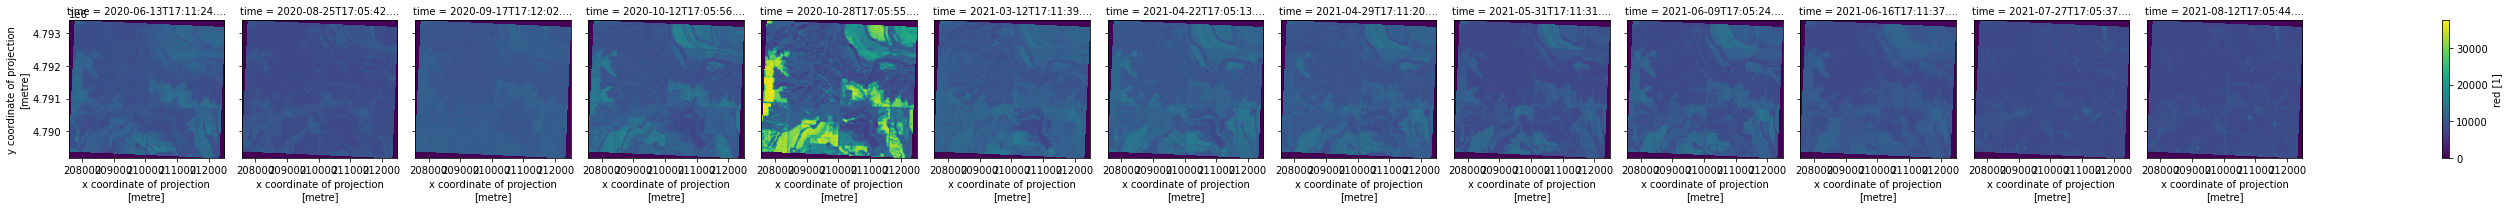

In [21]:
datacube.red.plot.imshow(col="time")


In [22]:
help(datacube.red.plot.imshow)

Help on method imshow in module xarray.plot.plot:

imshow(x, y, **kwargs) method of xarray.plot.plot._PlotMethods instance
    Image plot of 2D DataArray.
    
    Wraps :py:func:`matplotlib:matplotlib.pyplot.imshow`.
    
    While other plot methods require the DataArray to be strictly
    two-dimensional, ``imshow`` also accepts a 3D array where some
    dimension can be interpreted as RGB or RGBA color channels and
    allows this dimension to be specified via the kwarg ``rgb=``.
    
    Unlike :py:func:`matplotlib:matplotlib.pyplot.imshow`, which ignores ``vmin``/``vmax``
    for RGB(A) data,
    xarray *will* use ``vmin`` and ``vmax`` for RGB(A) data
    by applying a single scaling factor and offset to all bands.
    Passing  ``robust=True`` infers ``vmin`` and ``vmax``
    :ref:`in the usual way <robust-plotting>`.
    
    .. note::
        This function needs uniformly spaced coordinates to
        properly label the axes. Call :py:meth:`DataArray.plot` to check.
    
    Th

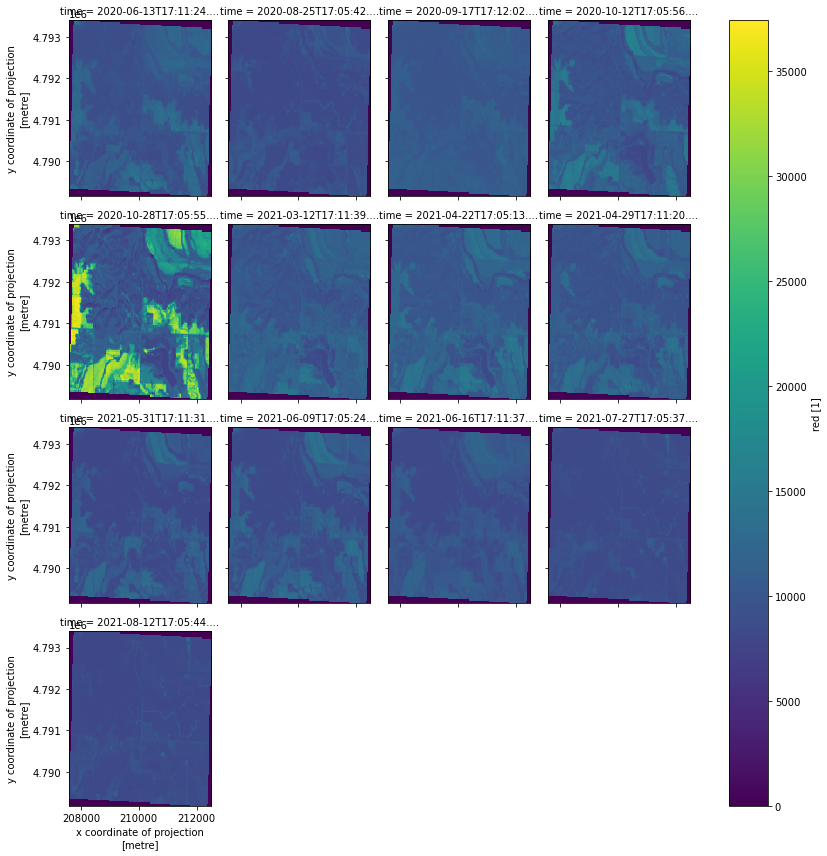

In [23]:
datacube.red.plot.imshow(col="time", col_wrap=4, figsize=(12,12))


In [24]:
from dask.distributed import Client, progress


client = Client()
client

Client Scheduler: tcp://127.0.0.1:33433 Dashboard: /user/butzer@contractor.usgs.gov/proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 15.00 GiB


In [25]:
DS=datacube

In [26]:
da_ndwi = (DS['green'] - DS['swir16']) / (DS['green'] + DS['swir16'])

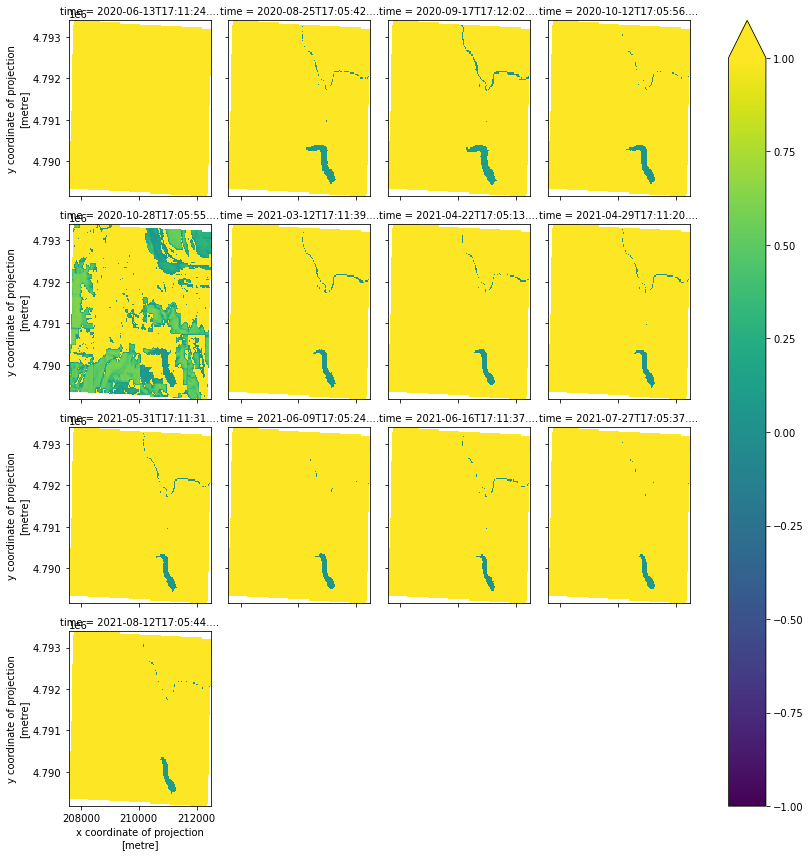

In [27]:
da_ndwi.plot.imshow(col="time", col_wrap=4, figsize=(12,12), vmin=-1, vmax=1)


In [28]:
da_ndwi

<xarray.DataArray (time: 13, y: 141, x: 164)>
dask.array<truediv, shape=(13, 141, 164), dtype=float64, chunksize=(1, 75, 164), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4.793e+06 4.793e+06 ... 4.789e+06 4.789e+06
  * x            (x) float64 2.076e+05 2.076e+05 ... 2.124e+05 2.125e+05
  * time         (time) datetime64[ns] 2020-06-13T17:11:24.796711 ... 2021-08...
    spatial_ref  int64 0

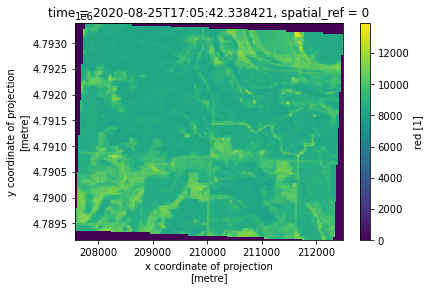

In [29]:
datacube['red'][1].plot()

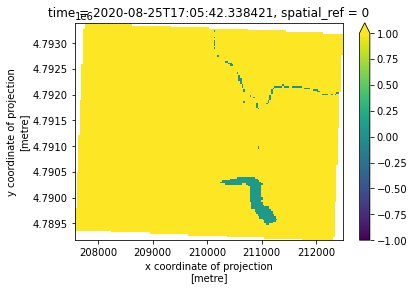

In [30]:
da_ndwi[1].plot(vmin=-1,vmax=1)

(array([ 382.,    0.,    0.,    0.,  434., 3098., 7374., 9412.,  500.,
         130.]),
 array([3.34784064e-04, 3.71647929e-01, 7.42961074e-01, 1.11427422e+00,
        1.48558736e+00, 1.85690051e+00, 2.22821365e+00, 2.59952680e+00,
        2.97083994e+00, 3.34215309e+00, 3.71346624e+00]),
 <BarContainer object of 10 artists>)

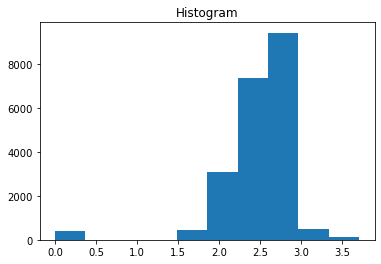

In [31]:
da_ndwi[1].plot.hist()

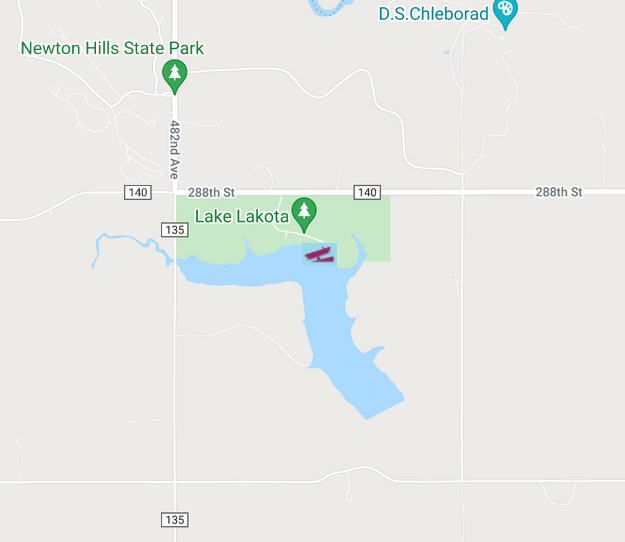

In [32]:
from IPython.display import display, Image
display(Image(filename='lakelakota-boatramp.PNG'))

In [33]:
dir(datacube)

['_HANDLED_TYPES',
 '__abs__',
 '__abstractmethods__',
 '__add__',
 '__and__',
 '__annotations__',
 '__array__',
 '__array_priority__',
 '__array_ufunc__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__contains__',
 '__copy__',
 '__dask_graph__',
 '__dask_keys__',
 '__dask_layers__',
 '__dask_optimize__',
 '__dask_postcompute__',
 '__dask_postpersist__',
 '__dask_scheduler__',
 '__dask_tokenize__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__orig_bases__',
 '__parameters__',
 '

In [34]:
"the code you want to test stays here"
end = time.time()
print(end - start)

47.814995527267456


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
